In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from keras.datasets import mnist
from sklearn.metrics import classification_report, adjusted_rand_score, adjusted_mutual_info_score

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(f'{x_train.shape = }')
print(f'{y_train.shape = }')
print(f'{x_test.shape = }')
print(f'{y_test.shape = }')

11490434/11490434 [==============================] - 1s 0us/step
x_train.shape = (60000, 28, 28)
y_train.shape = (60000,)
x_test.shape = (10000, 28, 28)
y_test.shape = (10000,)


In [4]:
# find indexes for images with the labels 0 and 4
train_idx = np.where((y_train == 0) | (y_train == 4))
test_idx = np.where((y_test == 0) | (y_test == 4))

x_train_sample = x_train[train_idx]
y_train_sample = y_train[train_idx]

x_test_sample = x_test[test_idx]
y_test_sample = y_test[test_idx]

print(f'{x_train_sample.shape = }')
print(f'{y_train_sample.shape = }')
print(f'{x_test_sample.shape = }')
print(f'{y_test_sample.shape = }')

x_train_sample.shape = (11765, 28, 28)
y_train_sample.shape = (11765,)
x_test_sample.shape = (1962, 28, 28)
y_test_sample.shape = (1962,)


In [6]:
class KMeansClassifier:
    def __init__(self, x, k: int = 2, iterations: int = 20, seed: int = 3):
        """
        :param x: array
        training data, must be in the format (n, dims).
        images can be used when reshaped from (n, y, x, c) to (n, y*x*c)
        :param k: int
        number of clusters to use for K-Means algorithm, default is 2
        :param iterations: int
        number of iterations, default is 20
        :param seed: int
        seed to use for random numbers, default is 3.
        """
        # set the seed and assign initial variables
        np.random.seed(seed)
        self.k = k
        self.dims = x.shape[1]
        self.x = x
        self.iterations = iterations
        self.viz = (False, False)
        
        # get max value of each dimension
        self.dim_lims = np.array(x.max(axis=0))
        
        # create a k*dim array of random init centroid coords
        # get coords by multiplying array of dimension limits by array of random floats
        self.centroids = np.array([np.array(self.dim_lims * np.random.rand(self.dims)) for i in range(k)])
        print(f'{self.centroids.shape[0]} clusters initialized...')
        
    def train(self, viz_it: bool = False, viz_fin: bool = False, debug: bool = False):
        """
        :param viz_it: bool
        indicate whether to visualize each iteration, default is False
        :param viz_fin: bool
        indicate whether to visualize the final clusters, default is False
        :param debug: bool
        indicate whether to include debug prints, default is False
        """

        print('Initializing...')
        self.viz = (viz_it, viz_fin)
        if debug:
            for c in range(self.centroids.shape[0]):
                print(f'Initial Centroid {c}: {self.centroids[c, :]}')
                
        if self.viz[0]:
            self.plot_clusters(self.x, None, step='Initial')
                
        for i in range(self.iterations):
            # print('-'*30)
            print(f'Iteration: {i}')
            if debug:
                for c in range(self.centroids.shape[0]):
                  print(f'Centroid {c}: {self.centroids[c, :]}')

            # get the closest cluster for each data point
            assignments = self.predict(self.x)
            
            # if all clusters contain at least 1 point, get all new clusters
            if all([any(assignments == j) for j in range(self.k)]):
                # get the coordinates of the new centroids by averaging the points in their clusters
                self.centroids = np.array([self.x[assignments == j, :].mean(axis=0) for j in range(self.k)])
                
            # if any clusters are empty, only update centroids containing points
            else:
                for j in range(self.k):
                    if any(assignments == j):
                        self.centroids[j, :] = self.x[assignments == j, :].mean(axis=0)
            
            if self.viz[0]:
                self.plot_clusters(self.x, assignments, step=f'Iteration {i}')

        # get the cluster assignments for each element in x
        assignments = self.predict(self.x)
        
        if self.viz[1]:
            self.plot_clusters(self.x, assignments, step='Final')
        
        return assignments

    def predict(self, x):
        # get the predicted cluster assignments
        assignments = get_clusters(self.centroids, x)
        return assignments
        
    def plot_clusters(self, x, assignments, step: str):
        # get color map
        cm = colormaps['viridis']
        cm_steps = cm(np.linspace(0, 1, self.k))

        # plot the clusters in different colors
        if assignments is not None:
            for j in range(self.k):
                cluster_points = x[assignments == j, :]
                plt.scatter(cluster_points[:, 0], 
                            cluster_points[:, 1], 
                            color=cm_steps[j], 
                            label=f'Cluster {j}')

        # if there are no assignments, plot all in one color
        else:
            plt.scatter(x[:, 0], 
                        x[:, 1], 
                        color=cm_steps[0], 
                        label='Initial Data')

        # plot the centroids
        plt.scatter(self.centroids[:, 0], 
                    self.centroids[:, 1], 
                    color='red', 
                    marker='x', 
                    s=100, 
                    label='Centroids')

        plt.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'{step} Clusters')
        plt.show()
        
        
def get_clusters(centroid_arr, arr, debug: bool = False):
    """
    :params: centroid_arr: array
    contains cluster centroids, format is (k, dims)
    :params: arr: array
    containing training data, format is (n, dims)
    :params: debug: bool
    indicate whether to include debug prints, default is False
    
    calculates the euclidian distance between all vectors in
    training set and centroids
    """
    
    # convert centroid_arr and arr into the necessary shapes for
    # array operations
    centroid_arr = centroid_arr[np.newaxis, ...]    
    arr = arr[:, np.newaxis, :]
    
    # calculate the euclidean distance between each point and centroid
    # dist = np.sqrt((arr - centroid_arr)**2).sum(axis=-1)
    dist = np.sqrt(((arr - centroid_arr)**2).sum(axis=-1))
    
    # get the index with the minimum distance for each point
    assignments = np.argmin(dist, axis=1)
    
    if debug:
        print(f'{centroid_arr.shape = }')
        print(f'{arr.shape = }')
        print(f'{dist.shape = }')
        print(f'{assignments.shape = }')

    return assignments

## MNIST Test

In [8]:
# train metrics
kmeans = KMeansClassifier(x_train_sample.reshape(11765, 784), 2, iterations=20, seed=3)
preds = kmeans.train()
y_train_sample[y_train_sample > 0] = 1
print(classification_report(y_train_sample, preds))

2 clusters initialized...
Initializing...
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      5923
           1       0.93      1.00      0.96      5842

    accuracy                           0.96     11765
   macro avg       0.96      0.96      0.96     11765
weighted avg       0.96      0.96      0.96     11765



In [10]:
# test metrics
test_preds = kmeans.predict(x_test_sample.reshape(1962, 784))
y_test_sample[y_test_sample > 0] = 1
print(classification_report(y_test_sample, test_preds))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       980
           1       0.95      1.00      0.97       982

    accuracy                           0.97      1962
   macro avg       0.97      0.97      0.97      1962
weighted avg       0.97      0.97      0.97      1962



## MNIST Test 2

In [ ]:
# train metrics
kmeans = KMeansClassifier(x_train.reshape(60000, 784), 10, iterations=30, seed=3)
preds = kmeans.train()

print(f'ARI: {adjusted_rand_score(y_train, preds)}')
print(f'AMI: {adjusted_mutual_info_score(y_train, preds)}')

10 clusters initiated...
Initializing...
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
ARI: 0.38950555867809056
AMI: 0.49228018969597537


In [ ]:
# test metrics
test_preds = kmeans.predict(x_test.reshape(10000, 784))

print(f'ARI: {adjusted_rand_score(y_test, test_preds)}')
print(f'AMI: {adjusted_mutual_info_score(y_test, test_preds)}')

ARI: 0.399507712778351
AMI: 0.5022608487187595


## Test 1

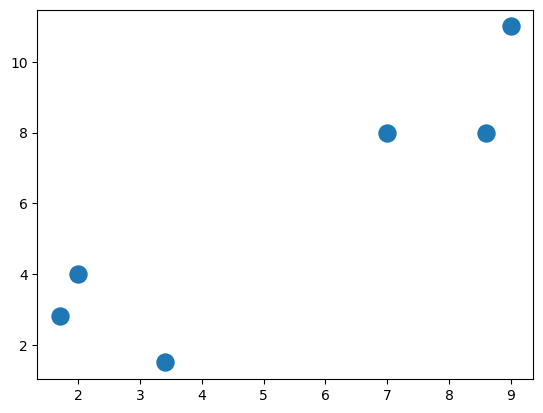

In [ ]:
x = np.array([[2, 4],
              [1.7, 2.8],
              [7, 8],
              [8.6, 8],
              [3.4, 1.5],
              [9, 11]])

plt.scatter(x[:,0], x[:,1], s=150)
plt.show()

2 clusters initialized...
Initializing...


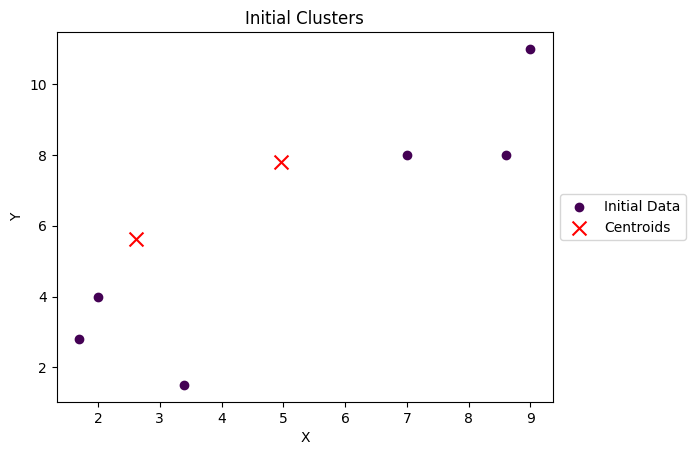

Iteration: 0


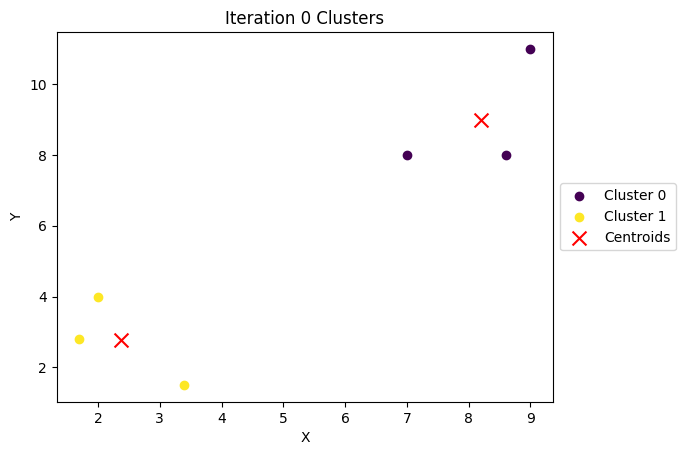

Iteration: 1


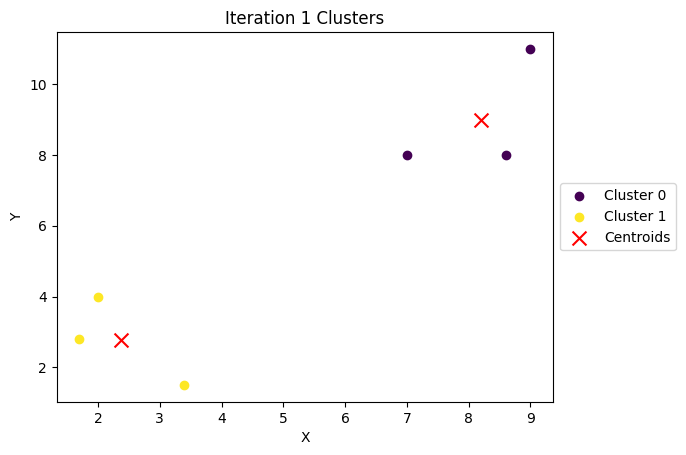

Iteration: 2


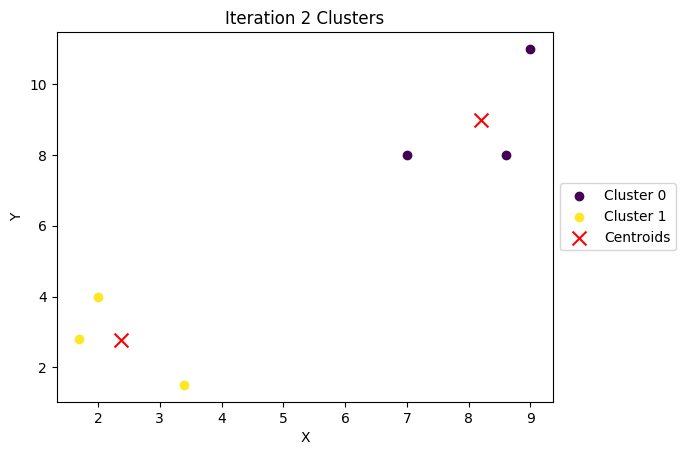

Iteration: 3


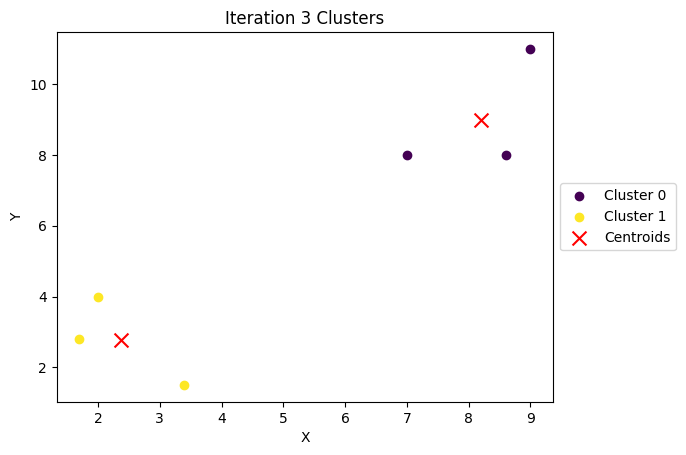

Iteration: 4


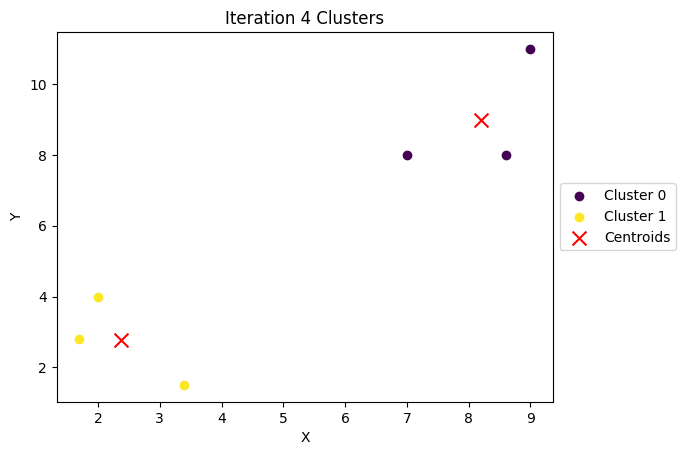

Iteration: 5


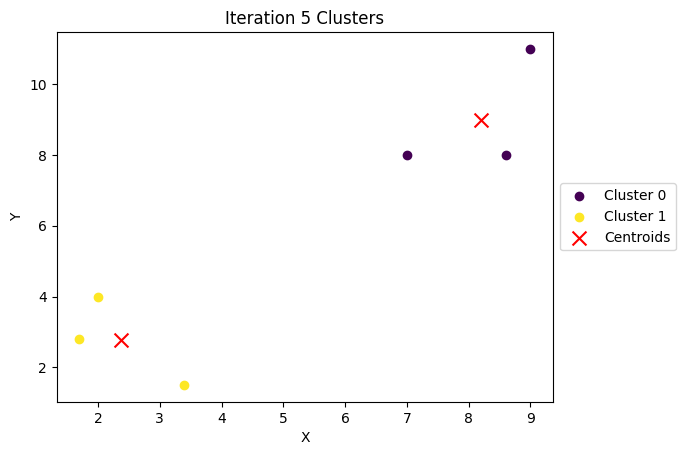

Iteration: 6


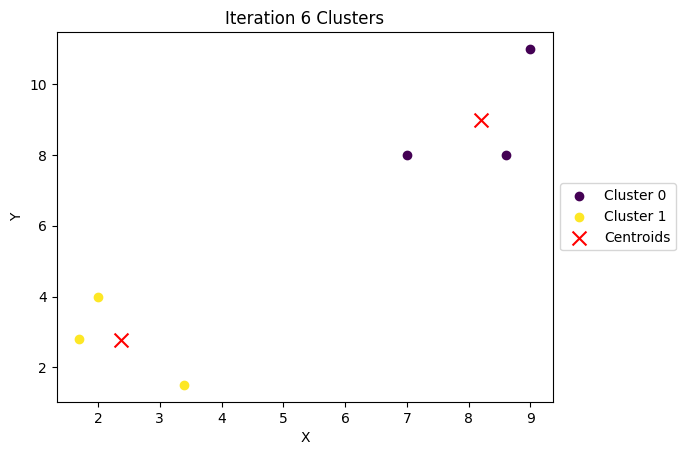

Iteration: 7


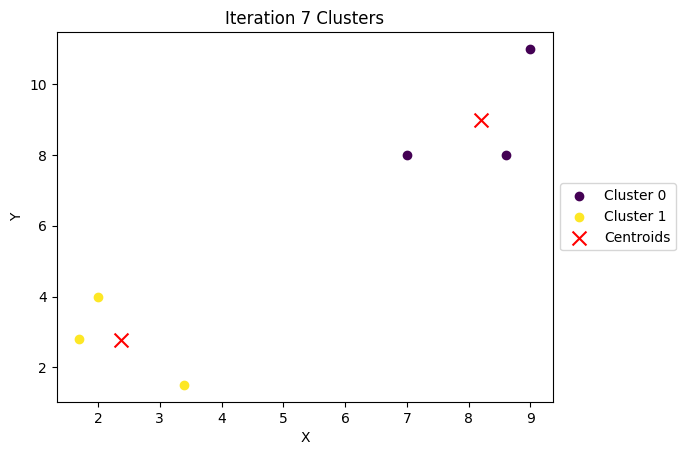

Iteration: 8


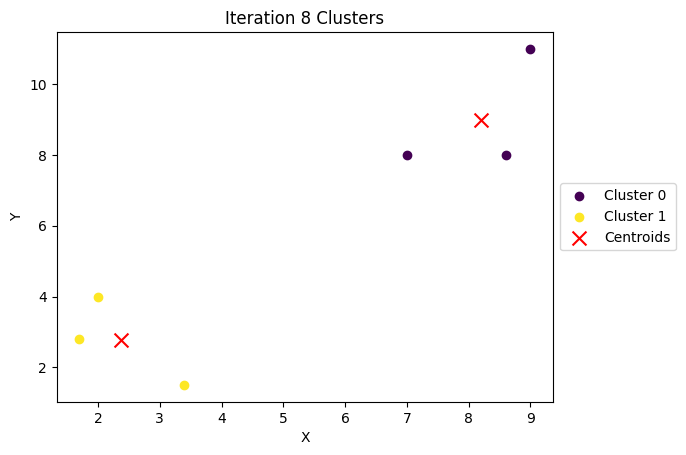

Iteration: 9


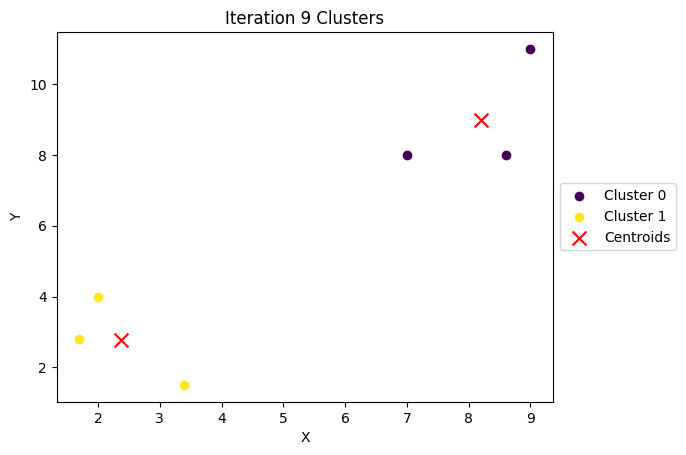

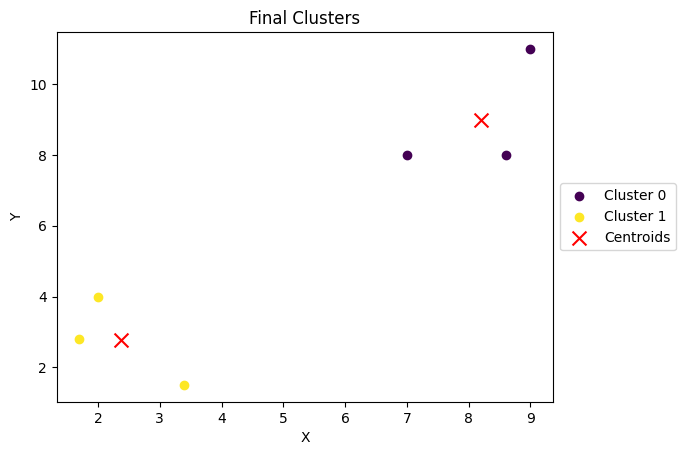

In [ ]:
kmeans = KMeansClassifier(x, 2, iterations=10, seed=3)
preds = kmeans.train(viz_it=True, viz_fin=True)

## Test 2

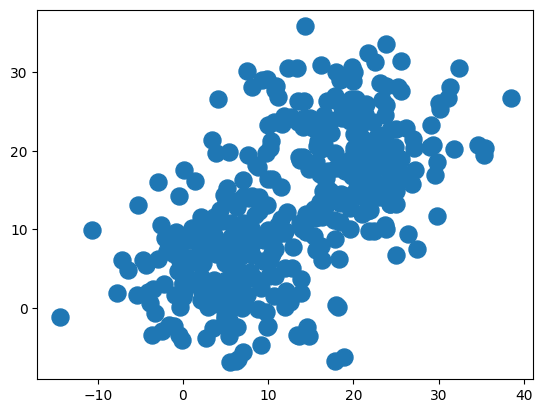

In [ ]:
# Set the seed for reproducibility
np.random.seed(42) 
# Parameters for the two normal distributions
mean1, std_dev1 = 5, 6
mean2, std_dev2 = 20, 6
# Generate points from two normal distributions
sample_size = 200
dist1 = np.random.normal(mean1, std_dev1, size=(sample_size, 2)) 
dist2 = np.random.normal(mean2, std_dev2, size=(sample_size, 2)) 
# Concatenate the points to create a bimodal distribution
x2 = np.vstack((dist1, dist2))
plt.scatter(x2[:,0], x2[:,1], s=150)
plt.show()

2 clusters initialized...
Initializing...


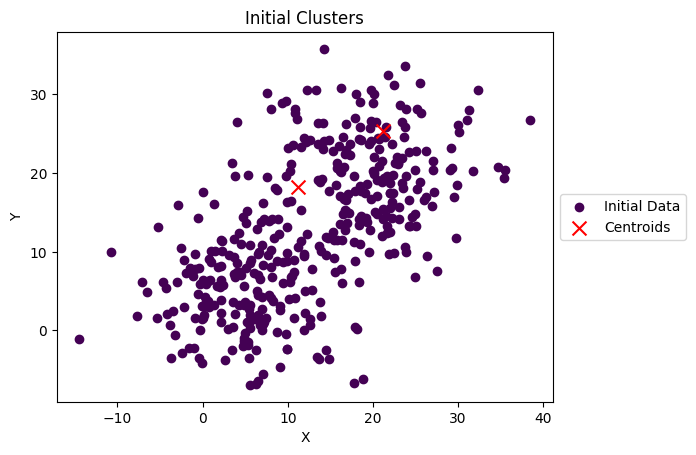

Iteration: 0


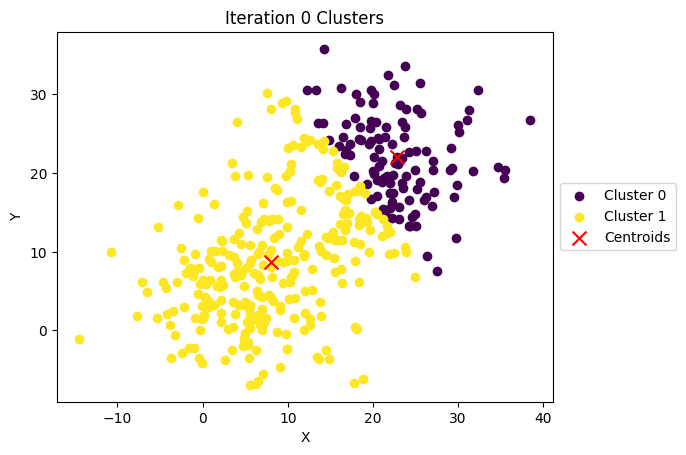

Iteration: 1


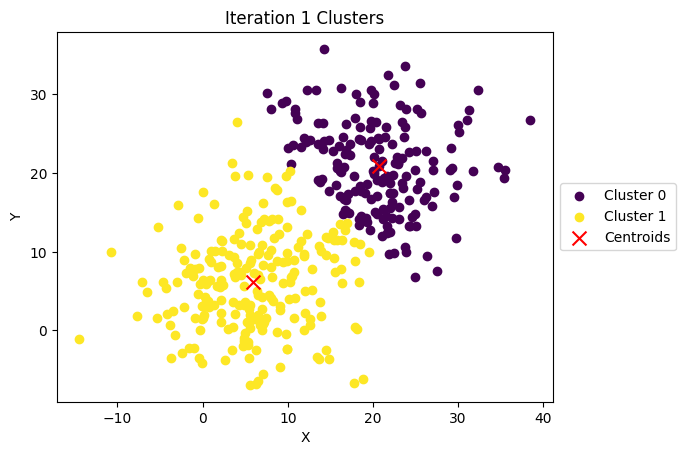

Iteration: 2


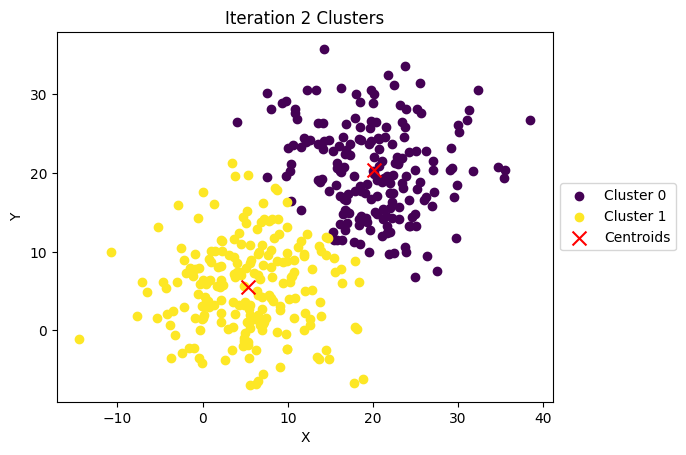

Iteration: 3


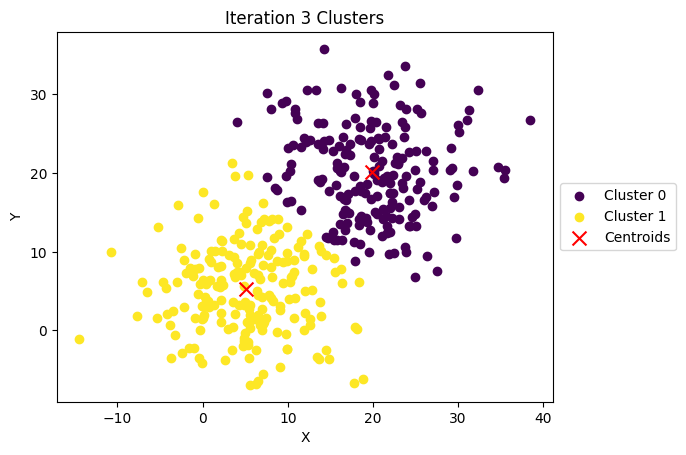

Iteration: 4


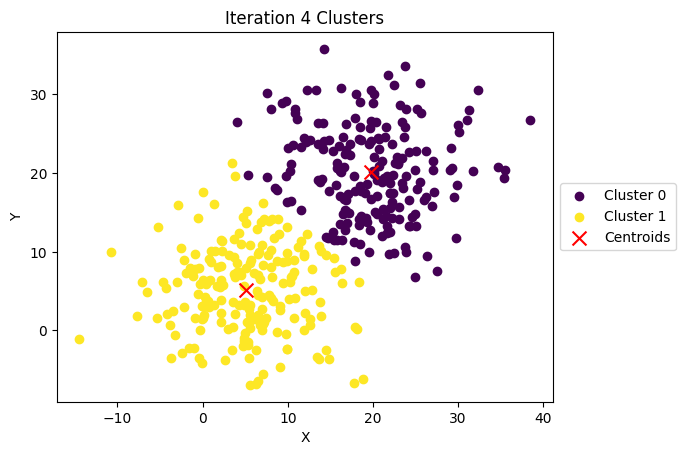

Iteration: 5


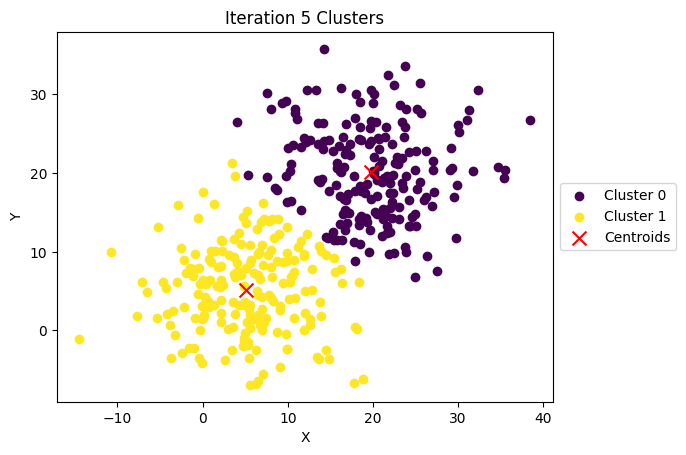

Iteration: 6


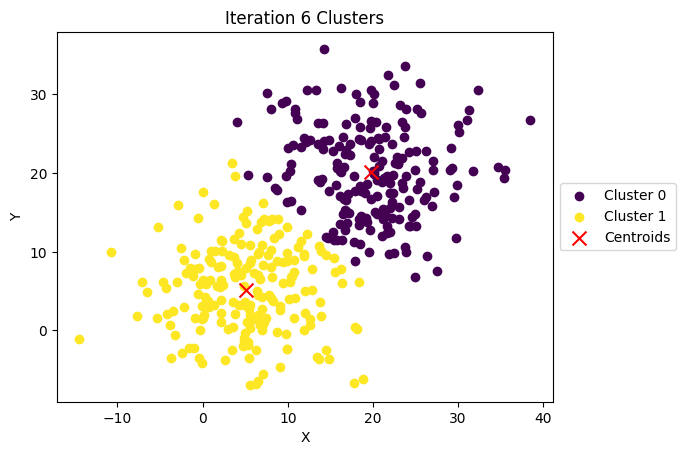

Iteration: 7


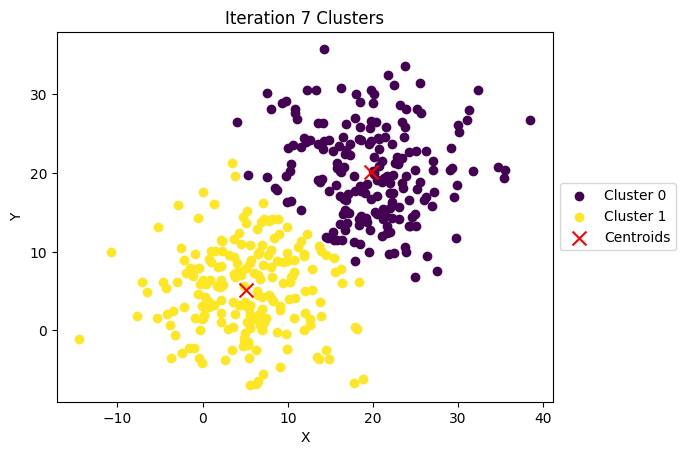

Iteration: 8


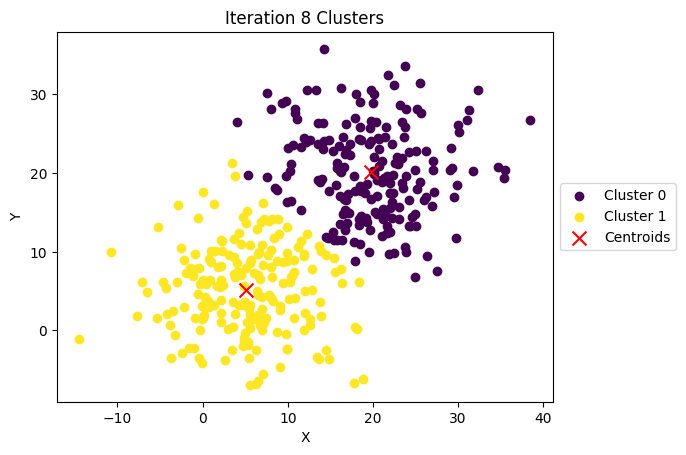

Iteration: 9


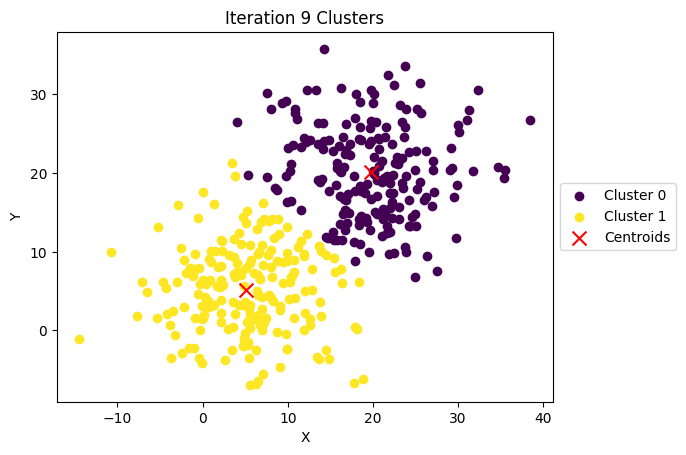

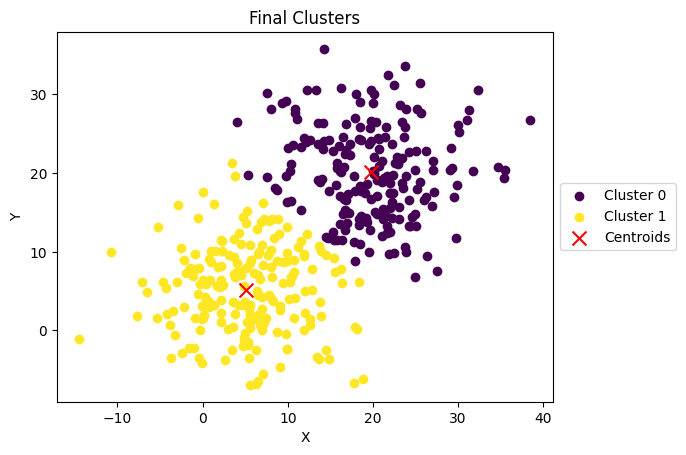

In [ ]:
kmeans = KMeansClassifier(x2, 2, iterations=10, seed=3)
preds = kmeans.train(viz_it=True, viz_fin=True)

## Test 3

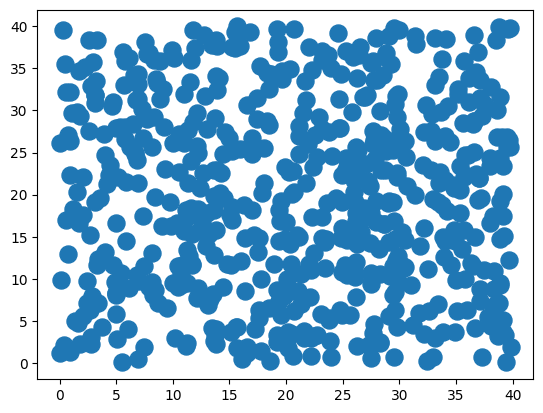

In [ ]:
x3 = 40 * (np.random.rand(600, 2))
plt.scatter(x3[:,0], x3[:,1], s=150)
plt.show()

4 clusters initialized...
Initializing...


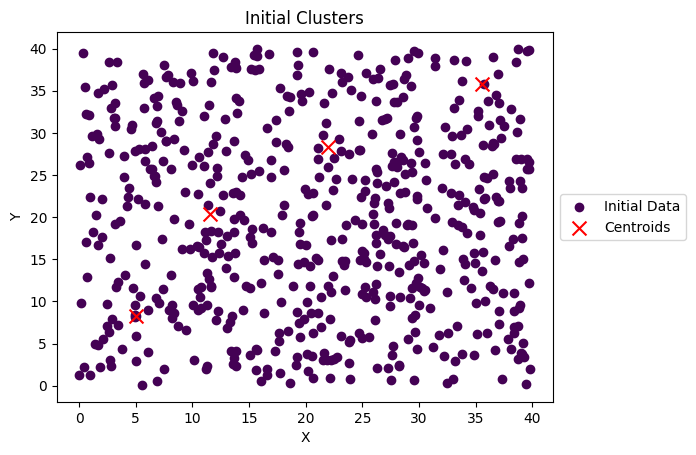

Iteration: 0


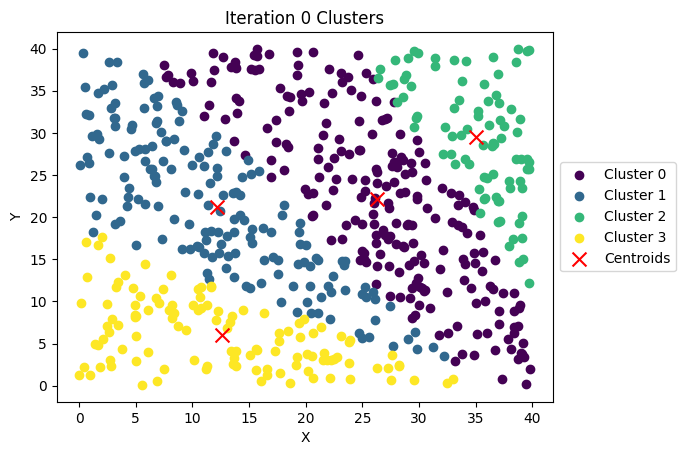

Iteration: 1


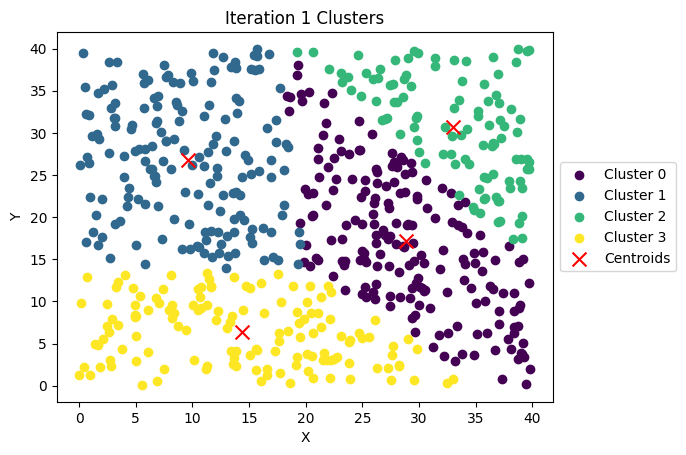

Iteration: 2


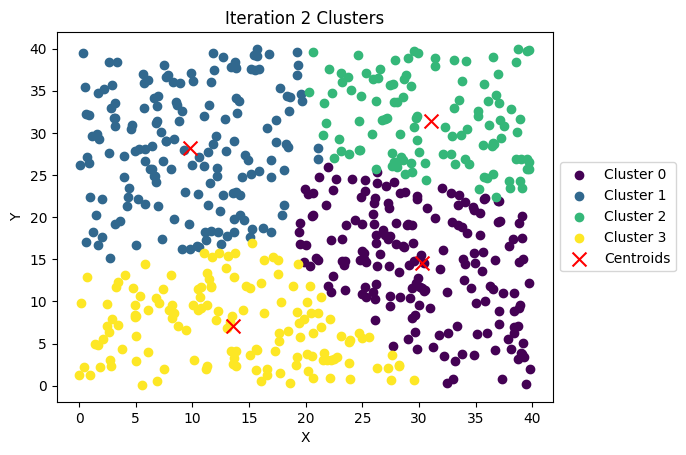

Iteration: 3


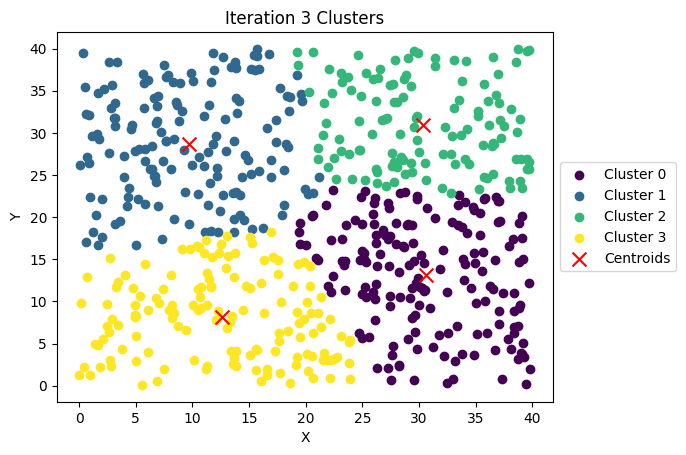

Iteration: 4


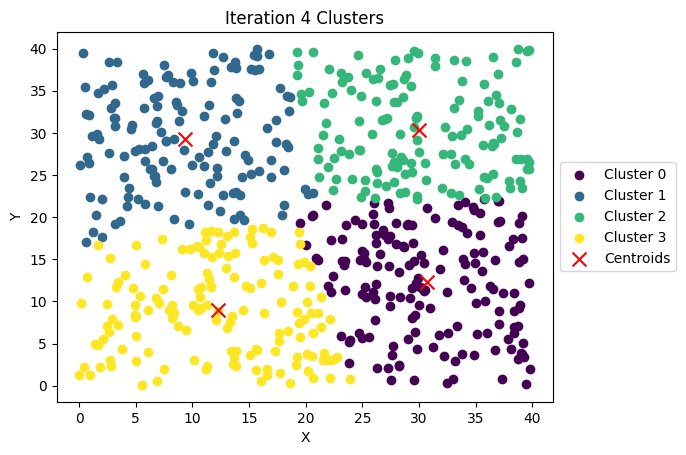

Iteration: 5


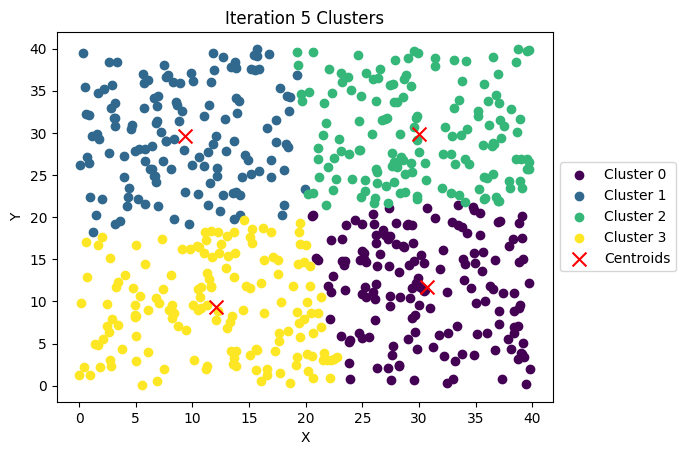

Iteration: 6


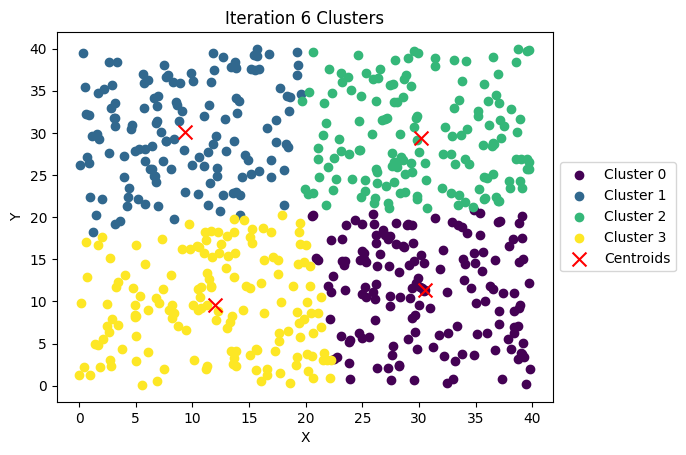

Iteration: 7


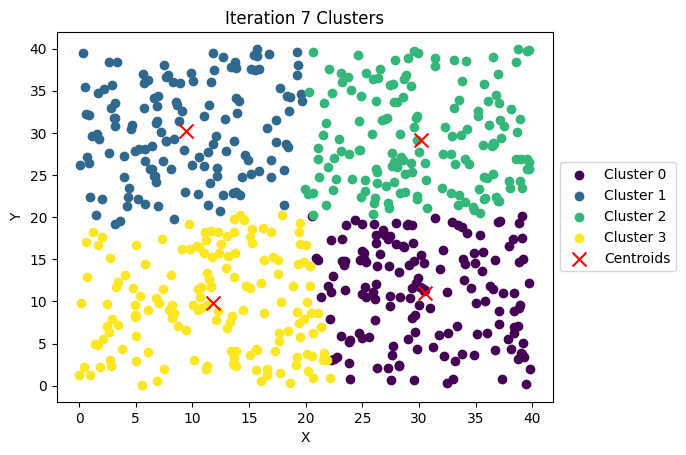

Iteration: 8


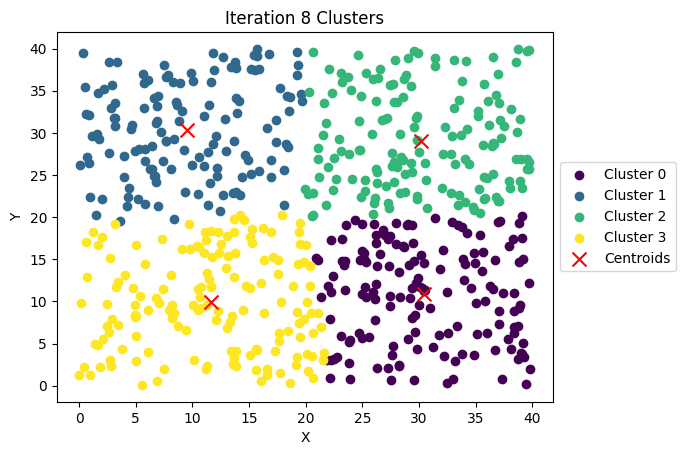

Iteration: 9


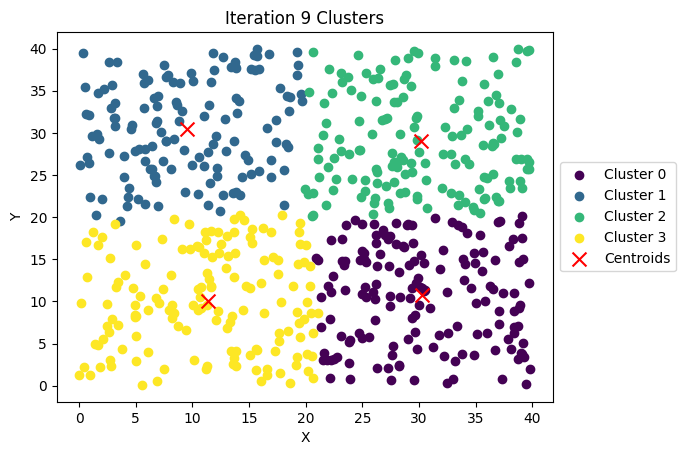

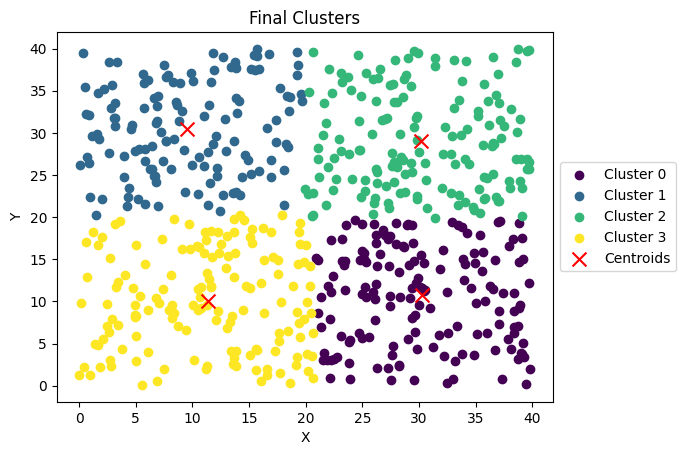

In [ ]:
kmeans = KMeansClassifier(x3, 4, iterations=10, seed=3)
preds = kmeans.train(viz_it=True, viz_fin=True)